# Run the simulation notebook for one set of parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from simulation_extended import *
from regions import CircleSkyRegion
from gammapy.makers import FoVBackgroundMaker

In [2]:
simulator = Simulation()
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg,
                             selection_optional=None)

The number of simulated obs is 4*n_obs, ie, n_obs is the number of runs simulated at each wobble position. For now, it is the same.
Can make it a list if really necessary

In [3]:
%%time
sigma = 0.3*u.deg
A0 = 5e-11
n_obs = 5
datasets = simulator.run(n_obs=n_obs, sigma=sigma, A0=A0)

Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0.7, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (359.3, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., 0.7)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., -0.7)>
CPU times: user 24.5 s, sys: 4.77 s, total: 29.2 s
Wall time: 29.3 s


(array([1., 1., 0., 3., 1., 3., 4., 3., 0., 4.]),
 array([0.825909 , 0.8620153, 0.8981216, 0.9342279, 0.9703342, 1.0064405,
        1.0425468, 1.0786531, 1.1147594, 1.1508657, 1.186972 ]),
 <BarContainer object of 10 artists>)

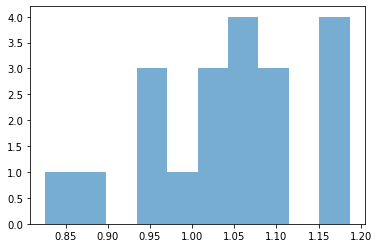

In [4]:
# The injected background systematics are stored in bkg_norms
plt.hist(simulator.bkg_norms, alpha=0.6)

In [5]:
# Stack the datasets for visualisation
stacked = datasets.stack_reduce()

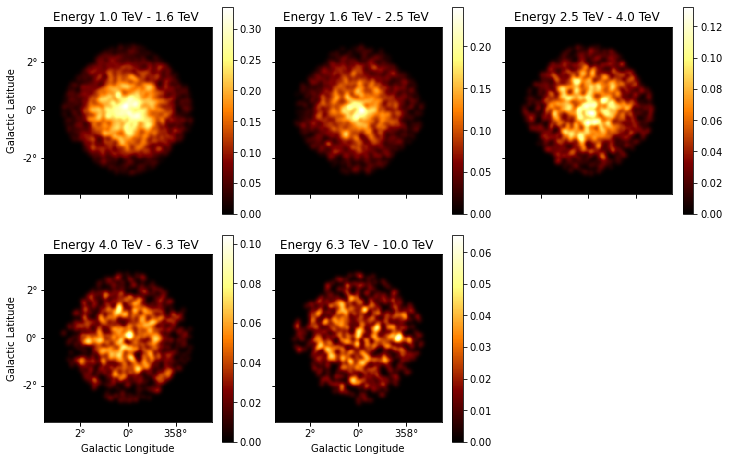

In [6]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

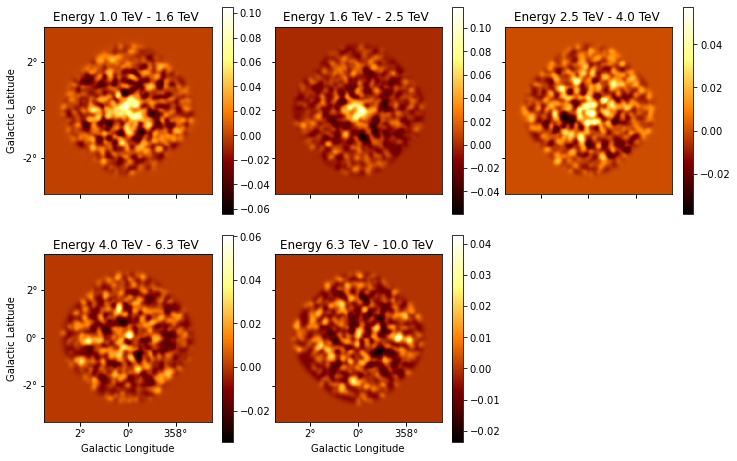

In [7]:
(stacked.counts - stacked.background).smooth(0.1*u.deg).plot_grid(add_cbar=True);

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x17712a668>)

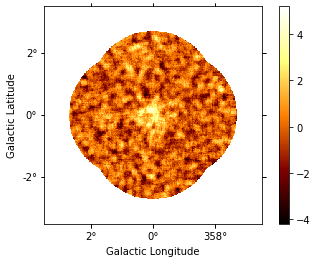

In [8]:
residual1 = estimator.run(stacked)
residual1['sqrt_ts'].plot(add_cbar=True)

In [9]:
#Source strength as a fraction of background
region = CircleSkyRegion(center=simulator.skydir,
                        radius=1.0*sigma)
bkg_strength = stacked.background.get_spectrum(region).data.sum()
src_strength = stacked.counts.get_spectrum(region).data.sum()
print(src_strength/bkg_strength - 1.0)

0.40904871246604424


In [10]:
#The injected model parameters
model = simulator.sky_model(sigma.value, A0)
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,int64
amplitude,4.5000e-12,cm-2 s-1,nan,nan,False,0.000e+00
index,2.3000e+00,,nan,nan,False,0.000e+00
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,0.0000e+00,deg,nan,nan,False,0.000e+00
lat_0,0.0000e+00,deg,-9.000e+01,9.000e+01,False,0.000e+00
sigma,3.0000e-01,deg,0.000e+00,nan,False,0.000e+00
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


## Extract with the ring background

In [11]:
from ring_background import *

In [12]:
mask = make_mask(datasets, 
                 source_pos=simulator.skydir, 
                 source_radius=2.0*sigma)

In [13]:
%%time
stacked_on_off = extract_ring(datasets=datasets,
                              exclusion_mask=mask
                             )

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value

CPU times: user 2.52 s, sys: 444 ms, total: 2.96 s
Wall time: 2.54 s


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/counts_statistic.py:233: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.n_on + self.alpha ** 2 * self.n_off)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x16b268198>)

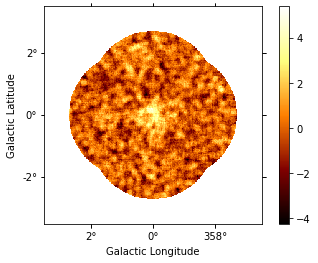

In [14]:
residual2 = estimator.run(stacked_on_off)
residual2['sqrt_ts'].plot(add_cbar=True)

Fit results: mu = -0.04, std = 0.97


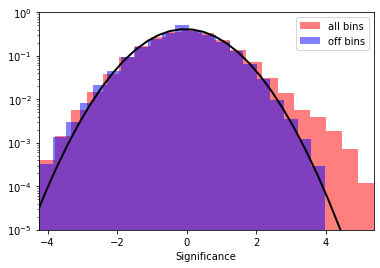

In [15]:
significance_map_off = residual2['sqrt_ts'] * mask
significance_all = residual2['sqrt_ts'].data[np.isfinite(residual2['sqrt_ts'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

Now, fit using the ring background

In [16]:
#define the sky_model to fit to the data
sky_model = model.copy(name='ring_fit')

In [17]:
L0 = stacked_on_off.stat_sum()

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [18]:
# Add the sky model to the dataset
stacked_on_off.models = sky_model

In [19]:
# Now fit
fit = Fit([stacked_on_off])
result = fit.run()
print(result)

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 207
	total stat : 38834.88



/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [20]:
print(result.parameters.to_table())

   name      value      unit      min        max    frozen   error  
--------- ----------- -------- ---------- --------- ------ ---------
amplitude  6.4646e-12 cm-2 s-1        nan       nan  False 9.079e-11
    index  3.4034e+00                 nan       nan  False 4.781e+00
     emin  1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax  1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0 -6.7714e-03      deg        nan       nan  False 1.219e+02
    lat_0 -4.3964e-02      deg -9.000e+01 9.000e+01  False 1.097e+04
    sigma  3.1052e-01      deg  0.000e+00       nan  False 1.182e+01
        e  0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi  0.0000e+00      deg        nan       nan   True 0.000e+00


In [21]:
L1 = stacked_on_off.stat_sum()
print('Detection del(TS) = ', L0-L1)

Detection del(TS) =  102.86388625627296


/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


## Now, fit using 3D stacked analysis

- using background models

In [22]:
#This is the background maker
# We fit the background before stacking
maker_fov = FoVBackgroundMaker(method="scale", 
                               exclusion_mask=mask)

In [23]:
%%time
stacked3D = MapDataset.create(
    geom=datasets[0]._geom, 
    energy_axis_true=datasets[0].exposure.geom.axes['energy_true'], 
    name="stacked3D"
)
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    stacked3D.stack(dataset)

CPU times: user 3.22 s, sys: 1.12 s, total: 4.33 s
Wall time: 4.34 s


In [24]:
print(stacked3D)

MapDataset
----------

  Name                            : stacked3D 

  Total counts                    : 13764 
  Total background counts         : 13411.68
  Total excess counts             : 352.32

  Predicted counts                : 13411.68
  Predicted background counts     : 13411.68
  Predicted excess counts         : nan

  Exposure min                    : 6.76e+08 m2 s
  Exposure max                    : 1.10e+10 m2 s

  Number of total bins            : 612500 
  Number of fit bins              : 267420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [25]:
model3D = model.copy(name='model3D')
bkg_model3D = FoVBackgroundModel(dataset_name="stacked3D")

In [26]:
stacked3D.models = bkg_model3D
L2 = stacked3D.stat_sum()

In [27]:
stacked3D.models = [bkg_model3D, model3D]

In [28]:
%%time
fit = Fit([stacked3D])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 9.896e+04               |     Ncalls=146 (146 total)     |
| EDM = 3.44e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 3.03 s, sys: 183 ms, total: 3.21 s
Wall time: 3.21 s


In [29]:
print(stacked3D.models.parameters.to_table())

   name      value      unit      min        max    frozen   error  
--------- ----------- -------- ---------- --------- ------ ---------
     norm  9.9458e-01                 nan       nan  False 9.648e-03
     tilt  0.0000e+00                 nan       nan   True 0.000e+00
reference  1.0000e+00      TeV        nan       nan   True 0.000e+00
amplitude  6.2715e-12 cm-2 s-1        nan       nan  False 9.721e-13
    index  2.8121e+00                 nan       nan  False 2.432e-01
     emin  1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax  1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0  1.6750e-02      deg        nan       nan  False 4.928e-02
    lat_0 -3.4323e-02      deg -9.000e+01 9.000e+01  False 4.796e-02
    sigma  3.1608e-01      deg  0.000e+00       nan  False 3.244e-02
        e  0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi  0.0000e+00      deg        nan       nan   True 0.000e+00


In [30]:
L3 = stacked3D.stat_sum()
print('Detection del(TS) = ', L2-L3)

Detection del(TS) =  99.74816212146834


## A joint 3D fitting

- This fits all the datasets together, 
- no stacking, it can be quite time consuming

In [31]:
maker_fov = FoVBackgroundMaker(method="fit", 
                               exclusion_mask=mask)
model3D_joint = model.copy(name='model3D_joint')
datasets_fit = Datasets()
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = [bkg_model, model3D_joint]
    datasets_fit.append(dataset)

In [32]:
datasets_fit.models.names

['dataset-0-0-bkg',
 'model3D_joint',
 'dataset-0-1-bkg',
 'dataset-0-2-bkg',
 'dataset-0-3-bkg',
 'dataset-0-4-bkg',
 'dataset-1-0-bkg',
 'dataset-1-1-bkg',
 'dataset-1-2-bkg',
 'dataset-1-3-bkg',
 'dataset-1-4-bkg',
 'dataset-2-0-bkg',
 'dataset-2-1-bkg',
 'dataset-2-2-bkg',
 'dataset-2-3-bkg',
 'dataset-2-4-bkg',
 'dataset-3-0-bkg',
 'dataset-3-1-bkg',
 'dataset-3-2-bkg',
 'dataset-3-3-bkg',
 'dataset-3-4-bkg']

In [33]:
%%time
fit_joint = Fit(datasets_fit)
result_joint = fit_joint.run()

CPU times: user 2min 48s, sys: 13.3 s, total: 3min 1s
Wall time: 3min 2s


In [34]:
model3D_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,float64
amplitude,6.4055e-12,cm-2 s-1,nan,nan,False,9.733e-13
index,2.8532e+00,,nan,nan,False,2.418e-01
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,1.1786e-02,deg,nan,nan,False,4.899e-02
lat_0,-2.3560e-02,deg,-9.000e+01,9.000e+01,False,4.639e-02
sigma,3.1659e-01,deg,0.000e+00,nan,False,3.215e-02
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


### Compare the injected background systematics vs the recompted ones

In [35]:
bkg_computed = []
bkg_err = []
for dataset in datasets_fit:
    bkg_computed.append(dataset.background_model.spectral_model.norm.value)
    bkg_err.append(dataset.background_model.spectral_model.norm.error)

Text(0, 0.5, 'reconstructed')

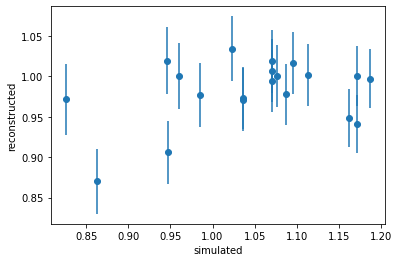

In [36]:
plt.errorbar(simulator.bkg_norms, bkg_computed, yerr=bkg_err, fmt='o')
plt.xlabel('simulated')
plt.ylabel('reconstructed')

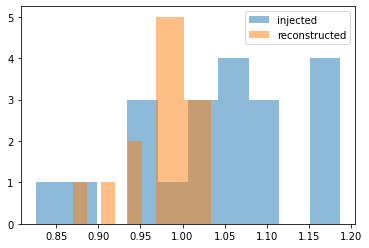

In [37]:

plt.hist(simulator.bkg_norms, alpha=0.5, label='injected')
plt.hist(bkg_computed, alpha=0.5, label = 'reconstructed')
plt.legend()